In [7]:
import sys
sys.path.append('../')

import optim_utils
import plot_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df_all.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [9]:
passes_df = pd.read_csv(PASSES_DF_PATH)

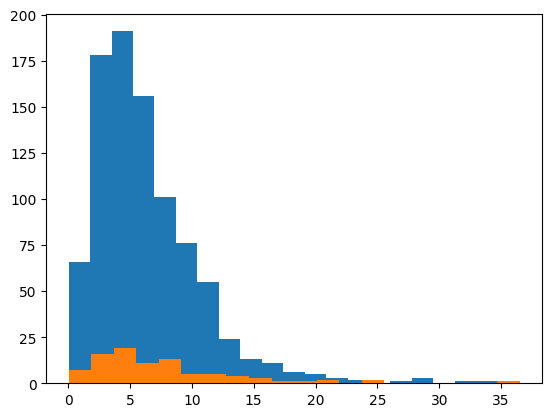

In [10]:
a = passes_df[passes_df['pass.accurate'] == True]
b = a[a['pass.recipient.id.skillcorner'] == a['tracking.object_id']]
c = b[['location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y', 'tracking.x', 'tracking.y']]

# find error between pass end location and tracking location
d = np.sqrt((c['pass.endLocation.x'] - c['tracking.x'])**2 + (c['pass.endLocation.y'] - c['tracking.y'])**2)
plt.hist(d, bins=20)

a = passes_df[passes_df['pass.accurate'] == False]
b = a[a['pass.recipient.id.skillcorner'] == a['tracking.object_id']]
c = b[['location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y', 'tracking.x', 'tracking.y']]

# find error between pass end location and tracking location
d = np.sqrt((c['pass.endLocation.x'] - c['tracking.x'])**2 + (c['pass.endLocation.y'] - c['tracking.y'])**2)
plt.hist(d, bins=20)

plt.show()

In [12]:
passes_df.frame.unique()[:10]

array([ 39,  77, 109, 151, 199, 226, 255, 293, 339, 369])

In [116]:
with pd.option_context('display.max_columns', None):
    display(passes_df[passes_df['pass.accurate'] == False])

,frame,matchPeriod,team.name,player.id.wyscout,player.id.skillcorner,pass.recipient.id.wyscout,pass.recipient.id.skillcorner,location.x,location.y,pass.endLocation.x,pass.endLocation.y,pass.accurate,play_direction,dxt,tracking.object_id,tracking.x,tracking.y,tracking.z,location.x.norm,location.y.norm,pass.endLocation.x.norm,pass.endLocation.y.norm,tracking.is_self,tracking.is_teammate,tracking.is_opponent,tracking.is_ball,responsibility,possible_interception_point,interception_point_x,interception_point_y,interception_xt,threat_by_pressing
690,1020,1,Netherland,535816,33512,625,7017,18.000000,-6.341538,15.882353,7.750769,False,TOP_TO_BOTTOM,0.000355,-1,18.11,-4.17,0.13,33,41,35,61,False,False,False,True,0.0,[17.68331843 -4.23411732],17.683318,-4.234117,0.025570,0.0
691,1020,1,Netherland,535816,33512,625,7017,18.000000,-6.341538,15.882353,7.750769,False,TOP_TO_BOTTOM,0.000355,7604,-32.87,-0.99,0.00,33,41,35,61,False,False,True,False,0.0,[16.09025495 6.36724355],16.090255,6.367244,0.023526,0.0
692,1020,1,Netherland,535816,33512,625,7017,18.000000,-6.341538,15.882353,7.750769,False,TOP_TO_BOTTOM,0.000355,16320,-2.19,-12.38,0.00,33,41,35,61,False,False,True,False,0.0,[18. -6.34153846],18.000000,-6.341538,0.025478,0.0
693,1020,1,Netherland,535816,33512,625,7017,18.000000,-6.341538,15.882353,7.750769,False,TOP_TO_BOTTOM,0.000355,11516,-3.63,0.06,0.00,33,41,35,61,False,False,True,False,0.0,[16.58164377 3.09719795],16.581644,3.097198,0.025421,0.0
694,1020,1,Netherland,535816,33512,625,7017,18.000000,-6.341538,15.882353,7.750769,False,TOP_TO_BOTTOM,0.000355,11630,0.85,-24.35,0.00,33,41,35,61,False,False,True,False,0.0,[18. -6.34153846],18.000000,-6.341538,0.025478,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22604,57469,2,Netherland,221069,10916,352988,11516,40.583333,5.636923,41.500000,2.818462,False,BOTTOM_TO_TOP,0.016771,20191,38.11,-0.33,0.00,89,42,90,46,False,False,True,False,0.0,[41.5 2.81846154],41.500000,2.818462,0.001331,0.0
22605,57469,2,Netherland,221069,10916,352988,11516,40.583333,5.636923,41.500000,2.818462,False,BOTTOM_TO_TOP,0.016771,12229,34.38,8.44,0.00,89,42,90,46,False,False,True,False,0.0,[40.58333333 5.63692308],40.583333,5.636923,0.001285,0.0
22606,57469,2,Netherland,221069,10916,352988,11516,40.583333,5.636923,41.500000,2.818462,False,BOTTOM_TO_TOP,0.016771,12246,36.38,12.47,0.00,89,42,90,46,False,False,True,False,0.0,[40.58333333 5.63692308],40.583333,5.636923,0.001285,0.0
22607,57469,2,Netherland,221069,10916,352988,11516,40.583333,5.636923,41.500000,2.818462,False,BOTTOM_TO_TOP,0.016771,6028,7.34,-6.70,0.00,89,42,90,46,False,False,True,False,0.0,[41.03186615 4.25782583],41.031866,4.257826,0.001306,0.0


In [125]:
def find_intented_receiver(frame):
    pass_df = passes_df[passes_df['frame'] == frame]
    pass_df = pass_df[pass_df['tracking.is_teammate'] & ~pass_df['tracking.is_self']]
    pass_end_x, pass_end_y = pass_df['pass.endLocation.x'], pass_df['pass.endLocation.y']
    pass_df['distance'] = np.sqrt((pass_df['tracking.x'] - pass_end_x)**2 + (pass_df['tracking.y'] - pass_end_y)**2)
    closest_player = pass_df.loc[pass_df['distance'].idxmin()]
    return closest_player['tracking.object_id']

In [126]:
def get_pass_info(passes_df, frame):
    pass_df = passes_df[passes_df['frame'] == frame]
    passer = pass_df['player.id.skillcorner'].values[0]
    recipient = pass_df['pass.recipient.id.skillcorner'].values[0]
    accurate = pass_df['pass.accurate'].values[0]
    return passer, recipient, float(accurate)

In [131]:
def predict_pass_success(frame):
    passer_location, recipients_info, defenders_info, play_direction = optim_utils.retrieve_player_positions(passes_df, frame)
    passer, recipient, label = get_pass_info(passes_df, frame)
    pass_succ_probs = optim_utils.pass_success_prob(passer_location, recipients_info, defenders_info)
    if recipient not in pass_succ_probs:
        recipient = find_intented_receiver(frame)
    pred_label = pass_succ_probs[recipient]['success_prob']
    return label, pred_label

In [162]:
labels = []
pred_labels = []
for frame in passes_df.frame.unique():
    label, pred_label = predict_pass_success(frame)
    labels.append(label)
    pred_labels.append(pred_label)

In [163]:
corr = np.corrcoef(labels, pred_labels)[0, 1]
print(f'Correlation: {corr}')

Correlation: 0.35510320830165837


In [164]:
best_thresh = 0.5
best_corr = -1
for t in np.arange(0.05, 1.0, 0.001):
    pred_labels_binary = [1 if x >= t else 0 for x in pred_labels]
    current_corr = np.corrcoef(labels, pred_labels_binary)[0, 1]
    if current_corr > best_corr:
        best_corr = current_corr
        best_thresh = t

print(f'Best Threshold: {best_thresh}, Best Correlation: {best_corr}')

Best Threshold: 0.21300000000000013, Best Correlation: 0.34894551424084924


In [165]:
thresh = 0.2
pred_labels_binary = [1 if x >= thresh else 0 for x in pred_labels]

corr = np.corrcoef(labels, pred_labels_binary)[0, 1]
print(f'Correlation: {corr}')

Correlation: 0.3159243646166225


In [180]:
# compute confusion matrix
labels = pd.Series(labels, name='Actual')
pred_labels_df = pd.Series(pred_labels_binary, name='Predicted')
df_confusion = pd.crosstab(labels, pred_labels_df)

In [181]:
import sklearn.metrics as metrics

In [182]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(labels, pred_labels)
roc_auc = metrics.auc(fpr, tpr)
print(f'AUC: {roc_auc}')

AUC: 0.7895296752519597


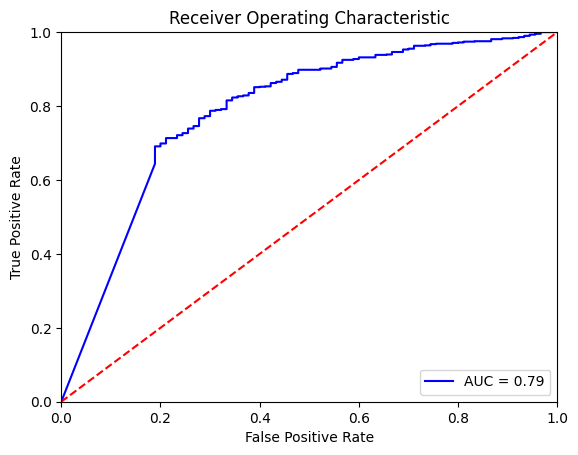

In [183]:
# plot roc curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [179]:
print(metrics.classification_report(labels, pred_labels_binary))

              precision    recall  f1-score   support

         0.0       0.32      0.48      0.38        90
         1.0       0.94      0.90      0.92       893

    accuracy                           0.86       983
   macro avg       0.63      0.69      0.65       983
weighted avg       0.89      0.86      0.87       983

